In [1]:
# %cd ..

In [2]:
import pickle
import torch
from train.model.performance import EpochPerformance
from utils.log import log_print
from utils.vars import softmax
from utils.analysis.plotting import plot_epoch_metrics
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, Iterable, Optional, List, Union, Dict
from pathlib import Path
from collections import OrderedDict
from itertools import cycle

In [3]:
TOP_FOLDER = "/home/cml0/rl-aux2/rl-aux/trained_models/"

In [4]:
def get_subfolders(folder: Union[str, Path], recursive: bool = True) -> List[Path]:
    root = Path(folder).expanduser().resolve()

    if not root.is_dir():
        raise NotADirectoryError(f"not a valid directory")
    subdirs = [str(p).split("/")[-1] for p in root.iterdir() if p.is_dir()]

    return subdirs


def get_epoch_data_from_dict(name_dictionary, k=None):
    epoch_datas = []

    for subfolder in get_subfolders(TOP_FOLDER):
        if subfolder not in name_dictionary:
            continue
        try:
            with open(TOP_FOLDER + subfolder + "/epoch_performances.pkl", 'rb') as file:
                epoch_data = pickle.load(file)
            if k:
                epoch_data=[epoch_data[i] for i in range(k)]
            epoch_datas.append((epoch_data, name_dictionary[subfolder]))
            #epoch_datas.append((epoch_data, subfolder))
        except:
            print(f"Couldn't creating epoch data for: {subfolder}")
    return epoch_datas

In [5]:
def _apply_labels_title(xlabel: Optional[str], ylabel: Optional[str], title: Optional[str]) -> None:
    """Helper to optionally set xlabel, ylabel, and title (leave blank if None)."""
    plt.title(title if title is not None else "")
    plt.xlabel(xlabel if xlabel is not None else "")
    plt.ylabel(ylabel if ylabel is not None else "")

def plot_epoch_metrics_bar(
    runs: Iterable[Tuple[Sequence, str]],
    *,
    j: int = 15,
    train: bool = False,
    aux: bool = False,
    include_loss: bool = False,
    figsize: Tuple[float, float] = (7, 4),
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    title: Optional[str] = None,
    colors: Optional[Dict[str, str]] = None,
    y_window: Optional[Tuple[float, float]] = None,
    label_order: Optional[Sequence[str]] = None,
) -> None:
    """Summarise metrics over the last *j* epochs as *bar charts*.

    Parameters
    ----------
    label_order : Sequence[str], optional
        Desired left‑to‑right ordering of **run labels** on the x‑axis. If
        provided, bars are arranged to match this sequence; otherwise, the
        original order (from *runs*) is preserved. This makes it easy to feed
        ``OrderedDict.keys()`` directly when you need a specific ordering.
    """

    suffix = "auxiliary" if aux else "primary"

    metrics: Dict[str, list] = {
        "test accuracy": [],
        "train accuracy": [],
    }
    if include_loss:
        metrics.update({"test loss": [], "train loss": []})

    # ------------------------------------------------------------------
    # Compute averages over trailing *j* epochs
    # ------------------------------------------------------------------
    for epoch_data, label in runs:
        if not epoch_data:
            continue  # skip empty runs

        if len(epoch_data) < j:
            print(
                f"[WARN] Run '{label}' only has {len(epoch_data)} epochs; using all of them for averaging."
            )
        window = epoch_data[-j:] if len(epoch_data) >= j else epoch_data
        n = len(window)

        # Average helper
        avg = lambda attr: sum(getattr(e, attr) for e in window) / n

        if include_loss:
            metrics["test loss"].append((label, avg(f"test_loss_{suffix}")))
        metrics["test accuracy"].append((label, avg(f"test_accuracy_{suffix}")))

        if train:
            if include_loss:
                metrics["train loss"].append((label, avg(f"train_loss_{suffix}")))
            metrics["train accuracy"].append((label, avg(f"train_accuracy_{suffix}")))

    # ------------------------------------------------------------------
    # Render bar charts
    # ------------------------------------------------------------------
    for metric, series in metrics.items():
        if not series:
            continue  # skip empty lists (e.g. train=False or include_loss=False)

        # ------------------------------------------------------------------
        # Resolve plotting order
        # ------------------------------------------------------------------
        if label_order is not None:
            order_map = {lbl: idx for idx, lbl in enumerate(label_order)}
            series = sorted(series, key=lambda t: order_map.get(t[0], float("inf")))

        labels, values = zip(*series)
        x_pos = range(len(labels))

        # Colours: honour explicit mapping; otherwise default cycle
        default_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
        bar_colors = [
            (colors[lbl] if colors and lbl in colors else next(default_cycle))
            for lbl in labels
        ]

        plt.figure(figsize=figsize)
        plt.bar(x_pos, values, color=bar_colors)
        plt.xticks(x_pos, labels, rotation=45, ha="right")

        # Annotate bars with numeric values (e.g. "0.738")
        for x, val in zip(x_pos, values):
            plt.text(x, val, f"{val:.3f}", ha="center", va="bottom", fontsize=9)

        _apply_labels_title(xlabel, ylabel, title)

        if y_window is not None:
            plt.ylim(*y_window)

        plt.grid(axis="y", linestyle=":", linewidth=0.5)
        plt.tight_layout()
        plt.show()



In [6]:
colors = {
    "Single Task (Baseline)": "green",
    "RL Auxiliary Task": "maroon",
    "MAXL (SOTA)": "navy",
    "RL Aux Task (OURS)": "maroon",
    "WA-MAXL (OURS)": "purple",
    "WA-RL Aux Task (OURS)": "blueviolet",
    "Human-Labeled Task": "orange",
    "RL 1x Weight": "maroon",
    "RL 2x Weight": "orange",
    "RL 4x Weight": "gold",
    "RL 0.5x Weight": "indigo",
    "RL 0.25x Weight": "navy",
}

In [53]:
sorted(get_subfolders(TOP_FOLDER))

['MAXL-WEIGHT_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR100-20',
 'MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10',
 'NONE_SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_PLACES365',
 'PPO_POST_AUX_LABEL_SOFTMAX_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20',
 'PPO_RESET_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20',
 'PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR10',
 'PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_PLACES365',
 'PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_SVHN',
 'PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10',
 'PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100',
 'PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_IMAGENET',
 'PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_PLACES36

In [54]:
for subfolder in sorted(get_subfolders(TOP_FOLDER)):
    if "SVHN" in subfolder:
        print(subfolder)
for subfolder in sorted(get_subfolders(TOP_FOLDER)):
    if "CIFAR10" in subfolder and "CIFAR100" not in subfolder:
        print(subfolder)
name_dictionary = {}
for subfolder in sorted(get_subfolders(TOP_FOLDER)):
    if "WAMAL" in subfolder and "CUB200" in subfolder:
        name_dictionary[subfolder] = subfolder

PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_SVHN
PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_SVHN
SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_SVHN
MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR10
PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10
SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10
WAMAL-MAXL_RESNET50_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
WAMAL-MAXL_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
WAMAL-MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
WAMAL-SINGLE_RESNET50_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
WAMAL-SINGLE_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
WAMAL_RESNET50_learn_weights_True_train_ratio_1_aux_weight_0_

In [55]:
# SHOW MAXL BASELINES

In [56]:
name_dictionary_ = {
    "MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20": "MAXL (SOTA)",
    "MAXL_BACKUP_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20": "MAXL backup",
    #"MAXL_VGG_train_ratio_0_aux_weight_0_obs_dim_0_CIFAR100-20": "MAXL (SOTA)",
    "NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20": "Single Task (Baseline)",
    "HUMAN_AUX_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20": "Human-Labeled Task",
    # "RANDOMIZED-PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20": "Randomized Task",
    "WAMAL-MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10": "Test",
    "MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10": "Test2"
}

In [57]:
epoch_datas = get_epoch_data_from_dict(name_dictionary)

Average test accuracy of WAMAL-SINGLE_RESNET50_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_0_CUB200: 0.6762
Average test accuracy of WAMAL-MAXL_RESNET50_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_0_CUB200: 0.6615
Average test accuracy of WAMAL_RESNET50_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CUB200: 0.6791


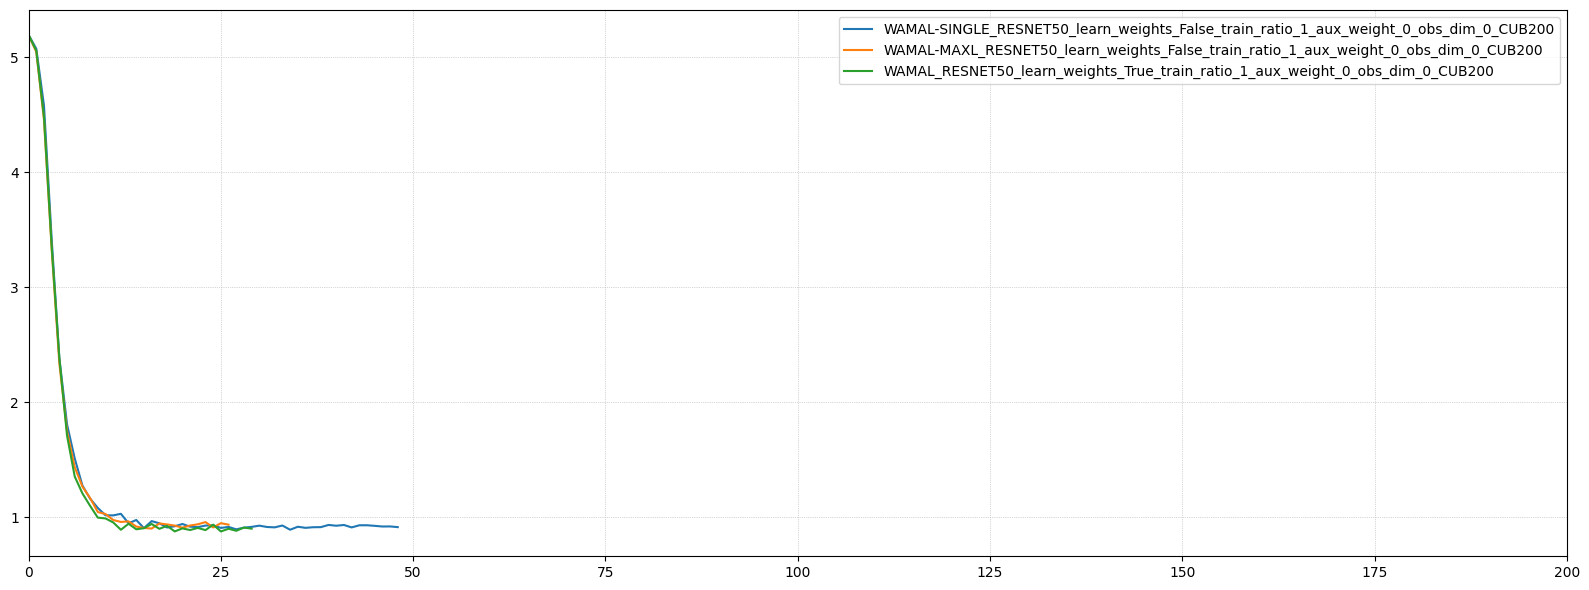

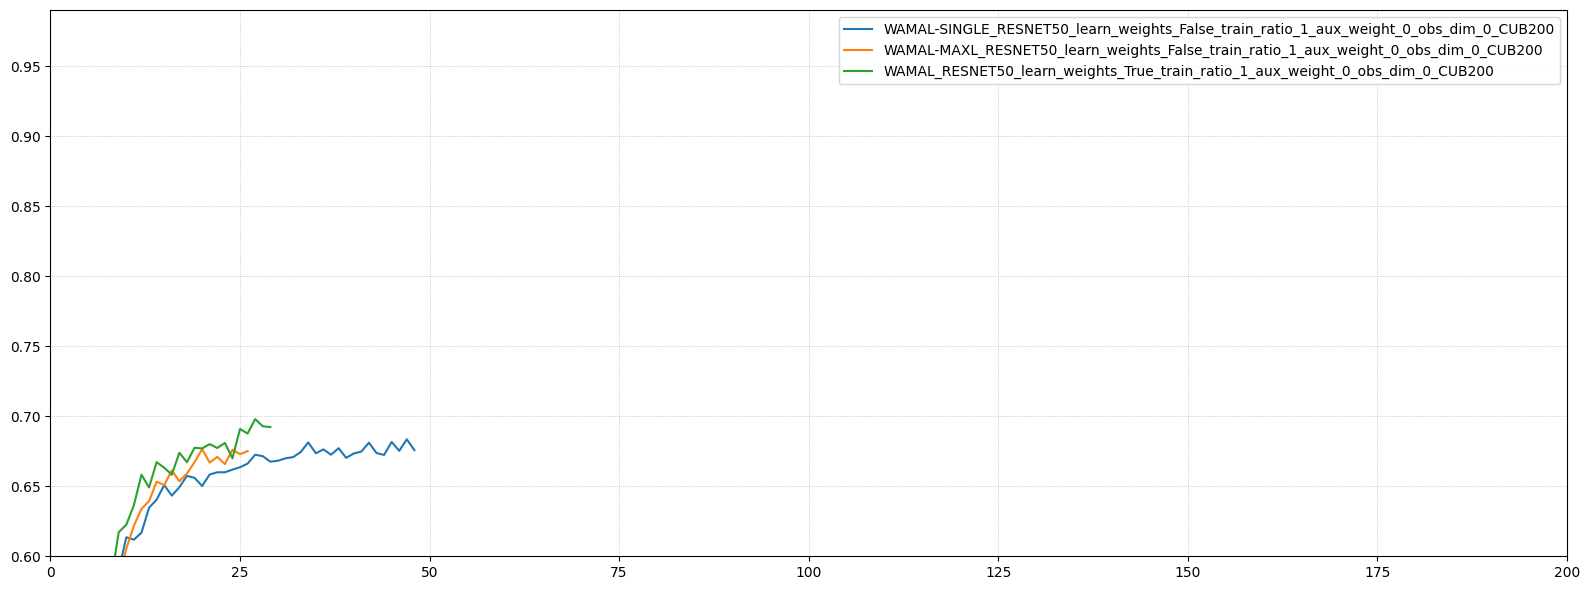

In [58]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.60,0.99), x_window=(0,200), figsize=(16,6), )

In [23]:
# SHOW RL Baseline with MAXL

In [14]:
name_dictionary = {
    "MAXL_BACKUP_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20": "MAXL (SOTA)",
    "NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20": "Single Task (Baseline)",
    "HUMAN_AUX_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20": "Human-Labeled Task",
    "PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20": "RL Auxiliary Task",
}

In [15]:
epoch_datas = get_epoch_data_from_dict(name_dictionary)

In [16]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.67,0.79), x_window=(0,200), figsize=(6,3.5), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.67,0.79),figsize=(6,3.5), ylabel="Accuracy",colors=colors)

In [17]:
# SHOW Weighted Approachs CIFAR100-20

In [18]:
# "WA-RL Aux Task (OURS)": "peru",
name_dictionary = OrderedDict([
    ('NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20',  'Single Task (Baseline)'),
    ("HUMAN_AUX_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20", "Human-Labeled Task"),
    ("MAXL_BACKUP_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20", "MAXL (SOTA)"),
    ("PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20", "RL Aux Task (OURS)"),
    ("PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20", "WA-RL Aux Task (OURS)"),
    ("MAXL-WEIGHT_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR100-20", "WA-MAXL Aux Task (OURS)"),
])


In [19]:
epoch_datas = get_epoch_data_from_dict(name_dictionary)

Average test accuracy of MAXL (SOTA): 0.7598
Average test accuracy of Human-Labeled Task: 0.7552
Average test accuracy of WA-RL Aux Task (OURS): 0.8089
Average test accuracy of Single Task (Baseline): 0.7186
Average test accuracy of RL Aux Task (OURS): 0.7619
Average test accuracy of WA-MAXL Aux Task (OURS): 0.8131


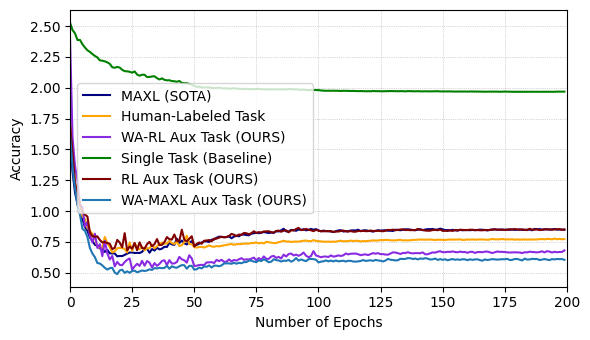

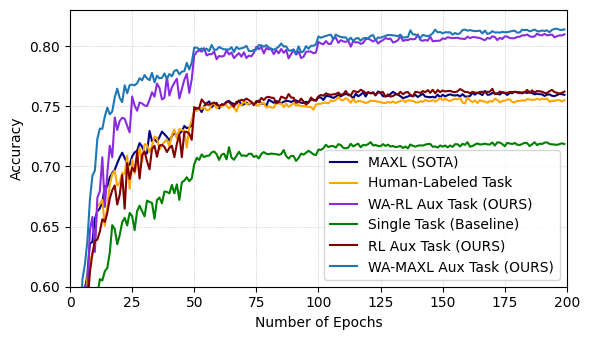

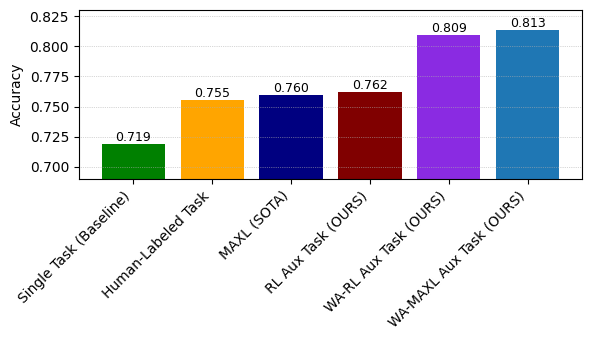

In [63]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.60,0.83), x_window=(0,200), figsize=(6,3.5), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.69,0.83),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()),colors=colors)

In [64]:
# Ablation with RL weight ratios

In [65]:
name_dictionary = OrderedDict([
    ('NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20',  'Single Task (Baseline)'),
    ('PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_0.25_obs_dim_256_CIFAR100-20', 'RL 0.25x Weight'),
    ('PPO_VGG_train_ratio_1_aux_weight_0.5_obs_dim_256_CIFAR100-20',           'RL 0.5x Weight'),
    ('PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20',   'RL 1x Weight'),
    ('PPO_VGG_train_ratio_1_aux_weight_2_obs_dim_256_CIFAR100-20',              'RL 2x Weight'),
    ('PPO_VGG_train_ratio_1_aux_weight_4_obs_dim_256_CIFAR100-20',              'RL 4x Weight'),
])


In [66]:
epoch_datas = get_epoch_data_from_dict(name_dictionary)

Average test accuracy of RL 0.25x Weight: 0.7312
Average test accuracy of RL 2x Weight: 0.7795
Average test accuracy of Single Task (Baseline): 0.7186
Average test accuracy of RL 0.5x Weight: 0.7434
Average test accuracy of RL 1x Weight: 0.7619
Average test accuracy of RL 4x Weight: 0.7878


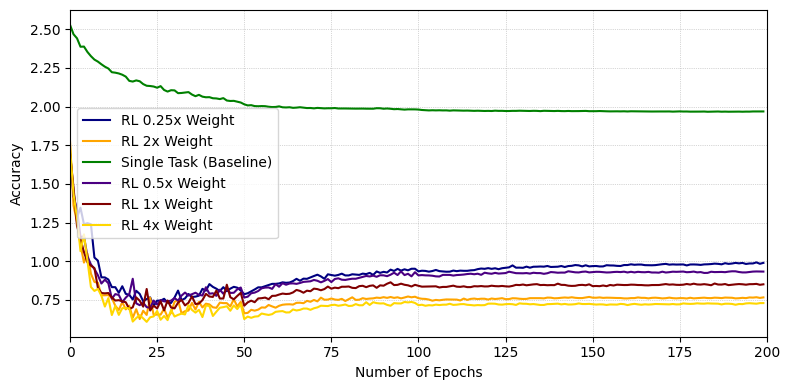

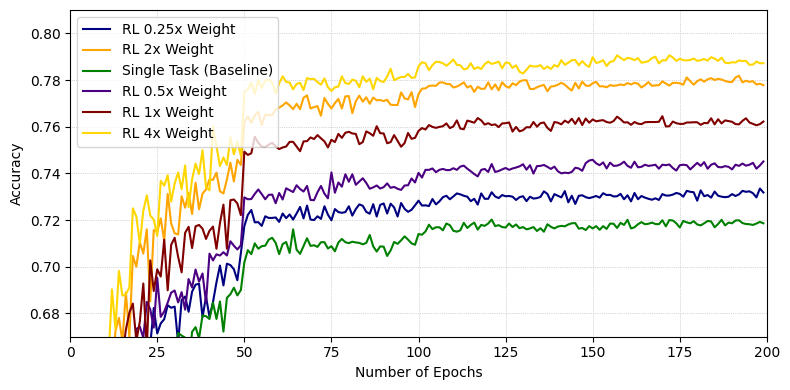

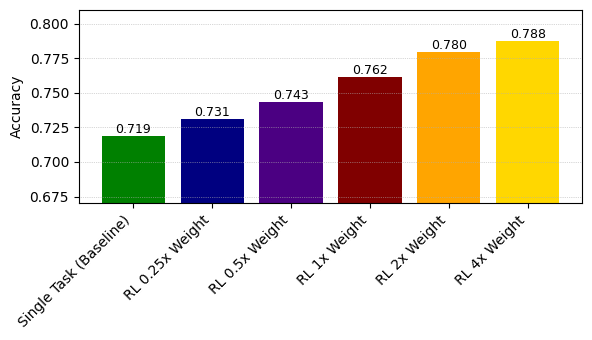

In [67]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.67,0.81), x_window=(0,200), figsize=(8,4), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.67,0.81),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()), colors=colors)

In [68]:
# SVHN

In [98]:
#MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_SVHN
#MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_SVHN
#PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_SVHN
#PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_SVHN
#SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_SVHN


name_dictionary = OrderedDict([
    ('SINGLETASK_VGG_learn_weights_False_train_ratio_1_aux_weight_0_obs_dim_256_SVHN',              'Single Task (Baseline)'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_SVHN',  'MAXL (SOTA)'),
    ('PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_SVHN',           'RL Aux Task (OURS)'),
    ('MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_SVHN', 'WA-MAXL (OURS)'),
    ('PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_SVHN',   'WA-RL Aux Task (OURS)'),
])

In [87]:
epoch_datas = get_epoch_data_from_dict(name_dictionary, 125)

Average test accuracy of Single Task (Baseline): 0.9456
Average test accuracy of RL Aux Task (OURS): 0.9555
Average test accuracy of MAXL (SOTA): 0.9566
Average test accuracy of WA-RL Aux Task (OURS): 0.9616
Average test accuracy of WA-MAXL (OURS): 0.9619


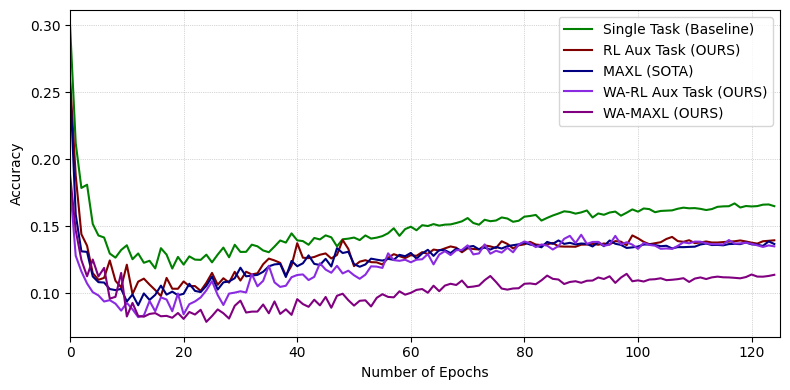

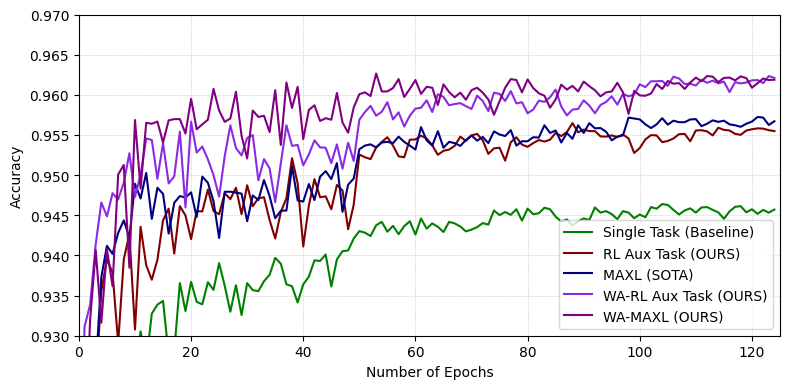

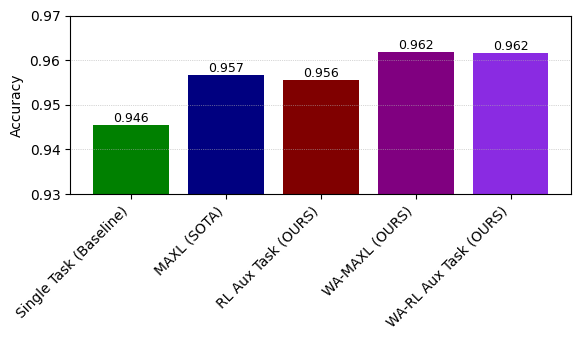

In [89]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.93,0.97), x_window=(0,125), figsize=(8,4), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.93,0.97),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()), colors=colors)

In [102]:
# Cifar10

In [103]:
# MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR10
# MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10
# NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10
# PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10
# PPO_VGG_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR10


name_dictionary = OrderedDict([
    ('NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10',              'Single Task (Baseline)'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR10',  'MAXL (SOTA)'),
    ('PPO_VGG_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR10',           'RL Aux Task (OURS)'),
    ('MAXL_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_0_CIFAR10', 'WA-MAXL (OURS)'),
    ('PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR10',   'WA-RL Aux Task (OURS)'),
])

In [104]:
epoch_datas = get_epoch_data_from_dict(name_dictionary,80)

Average test accuracy of RL Aux Task (OURS): 0.8932
Average test accuracy of WA-MAXL (OURS): 0.9250
Average test accuracy of Single Task (Baseline): 0.8601
Average test accuracy of WA-RL Aux Task (OURS): 0.9164
Average test accuracy of MAXL (SOTA): 0.8991


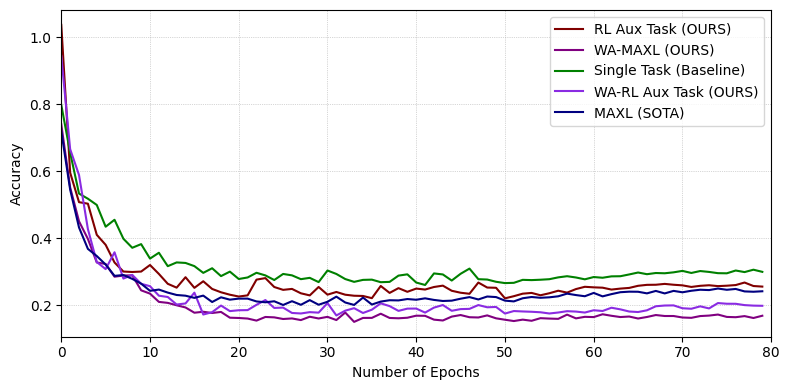

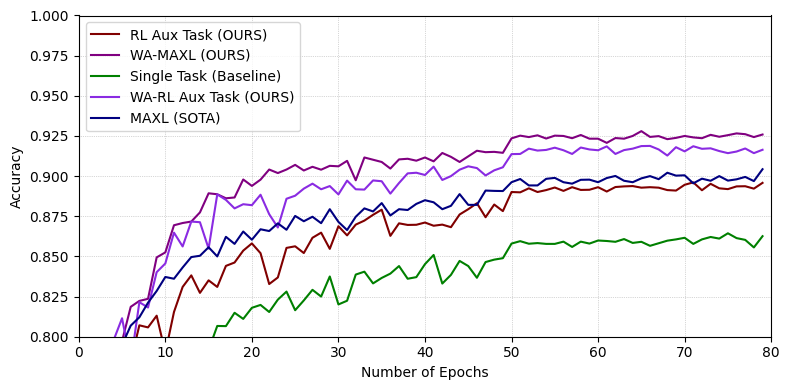

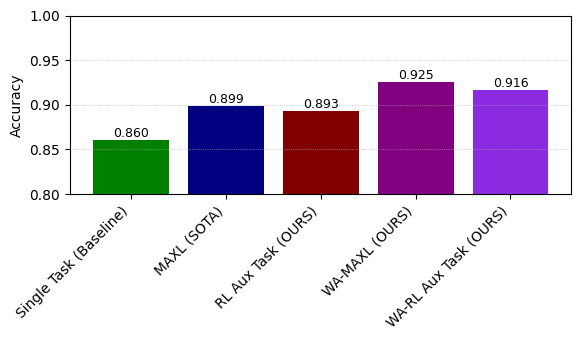

In [106]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.80,1), x_window=(0,80), figsize=(8,4), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.8,1),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()), colors=colors)

In [120]:
name_dictionary = OrderedDict([
    ('NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20',  'Single Task (Baseline)'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_0.25_obs_dim_0_CIFAR100-20', 'MAXL 0.25x Weight'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_0.5_obs_dim_0_CIFAR100-20',           'MAXL 0.5x Weight'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20',   'MAXL 1x Weight'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_2_obs_dim_0_CIFAR100-20',              'MAXL 2x Weight'),
    ('MAXL_VGG_learn_weights_False_train_ratio_0_aux_weight_4_obs_dim_0_CIFAR100-20',              'MAXL 4x Weight'),
])

In [121]:
epoch_datas = get_epoch_data_from_dict(name_dictionary, 200)

Average test accuracy of MAXL 1x Weight: 0.7628
Average test accuracy of Single Task (Baseline): 0.7186
Average test accuracy of MAXL 4x Weight: 0.7912
Average test accuracy of MAXL 2x Weight: 0.7742
Average test accuracy of MAXL 0.5x Weight: 0.7453
Average test accuracy of MAXL 0.25x Weight: 0.7330


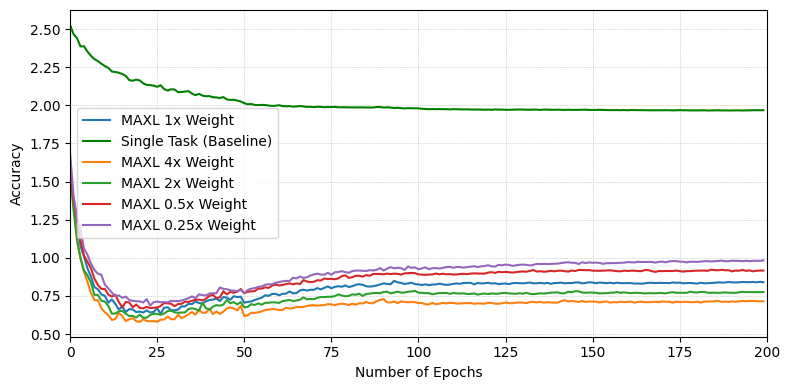

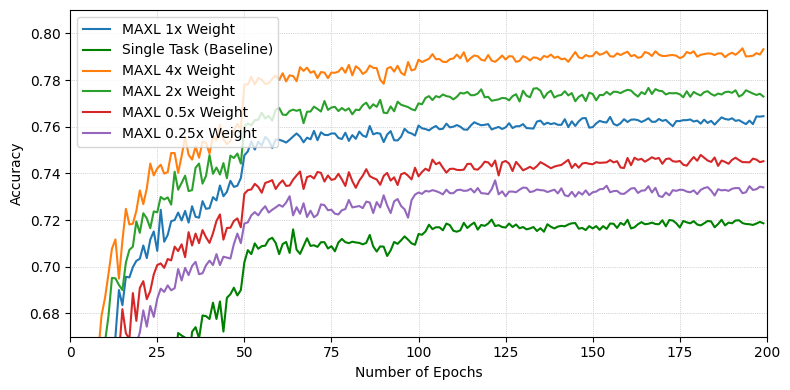

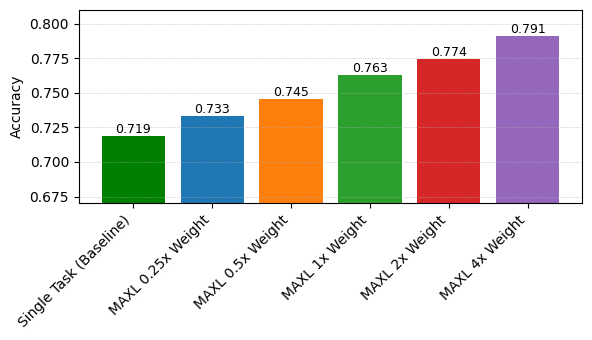

In [122]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.67,0.81), x_window=(0,200), figsize=(8,4), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.67,0.81),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()), colors=colors)

In [133]:
name_dictionary = OrderedDict([
    ('NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20',  'Single Task (Baseline)'),
    #("HUMAN_AUX_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20", "Human-Labeled Task"),
    ("RANDOMIZED-PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20", "Randomized Task"),
    ("PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20", "RL Aux Task"),
    ("PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20", "WA-RL Aux Task"),
])

In [134]:
epoch_datas = get_epoch_data_from_dict(name_dictionary, 200)

Average test accuracy of WA-RL Aux Task: 0.8089
Average test accuracy of Single Task (Baseline): 0.7186
Average test accuracy of RL Aux Task: 0.7619
Average test accuracy of Randomized Task: 0.7570


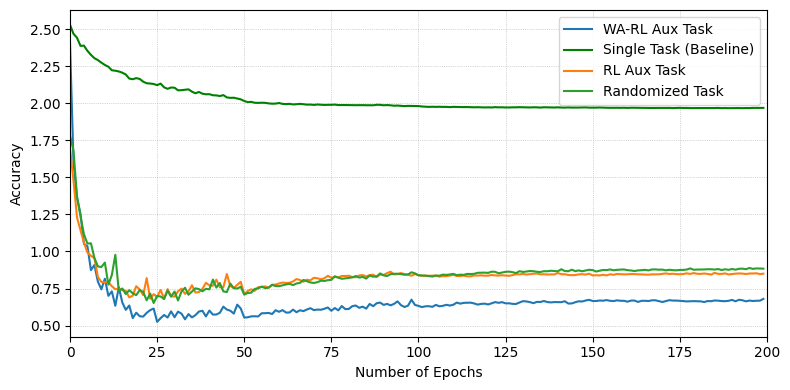

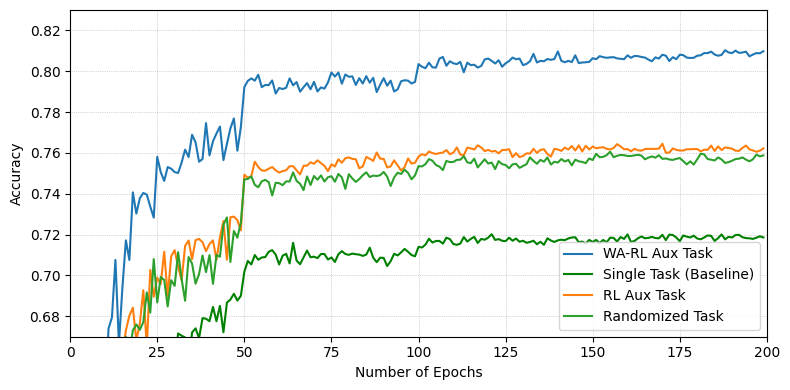

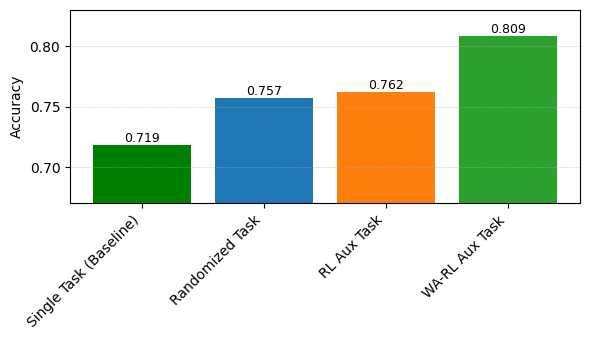

In [135]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.67,0.83), x_window=(0,200), figsize=(8,4), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.67,0.83),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()), colors=colors)

In [ ]:
name_dictionary = OrderedDict([
    ('NONE_SINGLETASK_VGG_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20',  'Single Task (Baseline)'),
    ("HUMAN_AUX_VGG_learn_weights_False_train_ratio_0_aux_weight_1_obs_dim_0_CIFAR100-20", "Human-Labeled Task"),
    ("PPO_RESET_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20", "RL Aux Task w/ Reset"),
    ("PPO_VGG_learn_weights_False_train_ratio_1_aux_weight_1_obs_dim_256_CIFAR100-20", "RL Aux Task"),
    ("PPO_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20", "WA-RL Aux Task"),
    ("PPO_RESET_VGG_learn_weights_True_train_ratio_1_aux_weight_0_obs_dim_256_CIFAR100-20", "WA-RL Aux Task w/ Reset"),
])

In [ ]:
epoch_datas = get_epoch_data_from_dict(name_dictionary, 200)

In [ ]:
plot_epoch_metrics(epoch_datas, y_window_acc=(0.67,0.83), x_window=(0,200), figsize=(8,4), xlabel="Number of Epochs", ylabel="Accuracy",colors=colors)
plot_epoch_metrics_bar(epoch_datas, y_window=(0.67,0.83),figsize=(6,3.5), ylabel="Accuracy", label_order=list(name_dictionary.values()), colors=colors)